In [1]:
import dask
from dask.distributed import Client, LocalCluster

# Workaround that dask does not kill workers while they are busy fetching data: https://dask.discourse.group/t/dask-workers-killed-because-of-heartbeat-fail/856
# maybe this helps: https://www.youtube.com/watch?v=vF2VItVU5zg?
from dask import config as cfg
cfg.set({'distributed.scheduler.worker-ttl': None})

import xarray as xr
import numpy as np
import  matplotlib.pyplot as plt
import os
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import  hold_canvas,  MultiCanvas #RoughCanvas,Canvas,
import imageio

In [2]:
# local cluster on current machine
# tempfolder = '/mnt/nas_Uwrite/fische_r/tmp'
# tempfolder = '/mpc/homes/fische_r/tmp'
tempfolder = '/mnt/SSD/fische_r/tmp'
dask.config.config['temporary-directory'] = tempfolder

cluster = LocalCluster(dashboard_address=':35000', memory_limit = '160GB', n_workers=6, threads_per_worker=20) 
client = Client(cluster)
print('Dashboard at '+cluster.dashboard_link)

Dashboard at http://127.0.0.1:35000/status


In [3]:
# # home-made cluster
# scheduler_address = "129.129.188.248:8786"
# client = Client(scheduler_address)
# print('Dashboard at '+client.dashboard_link)

In [4]:
from filter_functions import image_filter

In [5]:
import training_functions as tfs
from training_functions import train_segmentation


In [6]:
def on_mouse_down(x, y):
    global drawing
    global position
    global shape
    drawing = True
    position = (x, y)
    shape = [position]

def on_mouse_move(x, y):
    global drawing
    global position
    global shape
    if not drawing:
        return
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        position = (x, y)
    shape.append(position)

def on_mouse_up(x, y):
    global drawing
    global positiondu
    global shape
    drawing = False
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        canvas.fill_polygon(shape)
    shape = []

In [7]:
path = '/home/fische_r/NAS/testing/Jeremy_tomo/tomodata.nc'
featpath = '/home/fische_r/NAS/testing/Jeremy_tomo/featdata.nc'
# path = r"C:\Zwischenlager\tomodata.nc"
# path = '/mpc/homes/fische_r/wood3/wood_tomo.nc'
# featpath = '/mpc/homes/fische_r/wood3/featdata.nc'

path = '/home/fische_r/NAS/testing/TIM_tomo/tomodata.nc'
featpath = '/home/fische_r/NAS/testing/TIM_tomo/featdata.nc'

path = '/mpc/homes/fische_r/NAS/testing/TIM_tomo/tomodata_crop.nc'
featpath = '/mpc/homes/fische_r/NAS/testing/TIM_tomo/featdata.nc'

In [8]:
# chunksize = (40, 35, 40, 37)
chunks = {'x': 182, 'y':15, 'z':95, 'time':32}
# chunks = 'auto'

In [9]:
IF = image_filter(data_path=path, outpath = featpath, chunksize = chunks)

In [27]:
IF.open_raw_data()

In [20]:
# IF.open_lazy_data(chunks='auto')

In [21]:
# IF.data = IF.data[30:-20,15:-50,:100,:50] #cropping for wood

In [32]:
IF.data

dask.array<rechunk-merge, shape=(500, 169, 500, 140), dtype=uint16, chunksize=(125, 119, 125, 35), chunktype=numpy.ndarray>

In [29]:
# IF.data = IF.data[500:1000,:,:500,:140] #test croppping for Tim's data


In [30]:
# define new chunks based on auto-suggestion
# smaller chunks could help with many cpu, maybe xeperiminet a bit
# however, lazy looading seems super slow for custom chunks, maybe multiples of auto
# chunks = {'x': 182, 'y':15, 'z':95, 'time':32}

In [31]:
IF.data = IF.data.rechunk('auto')

In [17]:
# dataset = xr.open_dataset(path)
# data = dataset['tomo'][500:1000,:,:500,:140].data

In [18]:
# shp = data.shape
# coords = {'x': np.arange(shp[0]), 'y': np.arange(shp[1]), 'z': np.arange(shp[2]), 'time': np.arange(shp[3])}
# cropped_DS = xr.Dataset({'tomo': (['x','y','z','time'], data)},
#                          coords = coords
#                          )
# path = '/mpc/homes/fische_r/NAS/testing/TIM_tomo/tomodata_crop.nc'
# cropped_DS.to_netcdf(path)

In [33]:
IF.prepare()

In [50]:
IF.stack_features()

In [51]:
IF.feature_stack #rechunk feature stack? seems ok like dask does it itself

,Array,Chunk
Bytes,2.75 TiB,496.51 MiB
Shape,"(500, 169, 500, 140, 64)","(125, 119, 125, 35, 1)"
Count,255419 Tasks,8192 Chunks
Type,float64,numpy.ndarray


In [52]:
# IF.compute() #not sure what is more efficient, but I would compute the features and even store them on disk
# had the impression that otherwise many redundant operations happen, seems ok for really large datasets. so no idea ...

In [53]:
IF.make_xarray_nc()

In [54]:
# IF.make_xarray_nc(store=True)

In [55]:
# training_path = r"C:\Zwischenlager\Jeremy_tomo"
training_path = '/home/fische_r/NAS/testing/Jeremy_tomo'
training_path = '/mpc/homes/fische_r/wood3/'
training_path = '/mpc/homes/fische_r/NAS/testing/TIM_tomo/cropped'
if not os.path.exists(training_path):
    os.mkdir(training_path)

In [56]:
TS = train_segmentation(training_path=training_path)

In [57]:
TS.import_lazy_feature_data(IF.result, IF.original_dataset)

In [58]:
# TS.import_feature_data(IF.result)

### iterative training (even if you have a training set, maybe skip here)

In [59]:
def display_feature(i, TS):
    print('selected '+TS.feature_names[i])
    im = TS.current_feat_stack[:,:,i]
    im8 = im-im.min()
    im8 = im8/im8.max()*255
    return im8

In [30]:
# re-training for lazy data super slow, better use the the coordinates of this list and run the cells here for now
os.listdir(os.path.join(training_path, 'label_images'))

['label_image_z_270_time_100_.tif',
 'label_image_y_130_time_0_.tif',
 'label_image_y_140_time_100_.tif',
 'label_image_y_120_time_55_.tif',
 'label_image_y_40_time_0_.tif',
 'label_image_x_150_time_0_.tif',
 'label_image_y_130_time_120_.tif',
 'label_image_y_110_time_120_.tif',
 'label_image_y_120_time_0_.tif',
 'label_image_y_130_time_90_.tif',
 'label_image_x_150_time_75_.tif',
 'label_image_x_364_time_0_.tif',
 'label_image_y_150_time_0_.tif',
 'label_image_y_120_time_50_.tif',
 'label_image_y_110_time_80_.tif',
 'label_image_y_150_time_60_.tif',
 'label_image_z_250_time_130_.tif',
 'label_image_x_150_time_60_.tif',
 'label_image_y_120_time_45_.tif',
 'label_image_y_120_time_60_.tif',
 'label_image_y_110_time_0_.tif']

In [31]:
TS.suggest_training_set()

You could try  x = 219  and  y = 117
However, please sort it like the original xyztime


In [402]:
c1 = 'y'
p1 = 137
c2 = 'time'
p2 = 77

In [403]:
TS.load_training_set(c1, p1, c2, p2)

In [414]:
alpha = 0.35
im8 = TS.current_im8

#trick: use gaussian_time_4_0 to label static phases (-10)
# im8 = display_feature(-10, TS)

resultim = TS.current_result
width = im8.shape[1]
height = im8.shape[0]
Mcanvas = MultiCanvas(4, width=width, height=height)
background = Mcanvas[0]
resultdisplay = Mcanvas[2]
truthdisplay = Mcanvas[1]
canvas = Mcanvas[3]
canvas.sync_image_data = True
drawing = False
position = None
shape = []
image_data = np.stack((im8, im8, im8), axis=2)
background.put_image_data(image_data, 0, 0)
resultdisplay.global_alpha = alpha
if np.any(resultim>0):
    result_data = np.stack((255*(resultim==0), 255*(resultim==1), 255*(resultim==2)), axis=2)
else:
    result_data = np.stack((0*resultim, 0*resultim, 0*resultim), axis=2)
resultdisplay.put_image_data(result_data, 0, 0)
canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)
picker = ColorPicker(description="Color:", value="#ff0000")
slidealpha = IntSlider(description="Result overlay", value=0.15)
link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))
HBox((Mcanvas, picker, slidealpha))

In [415]:
# tfs.plot_im_histogram(im8)
# im8 = tfs.adjust_image_contrast(TS.current_im8, 0,100)

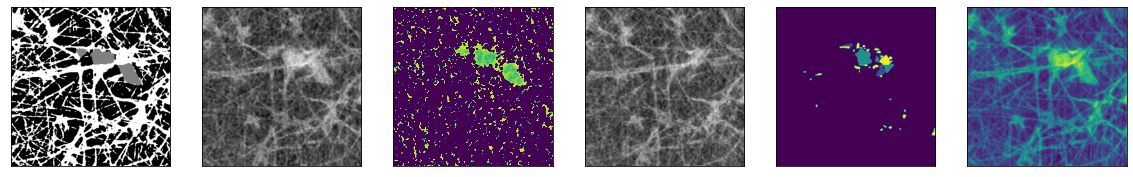

In [416]:
fig, axes = plt.subplots(1,6, figsize=(20,10))
axes[0].imshow(TS.current_result, 'gray')
axes[1].imshow(TS.current_im8, 'gray')

# TS.current_diff_im = TS.current_im-TS.current_first_im
# TS.current_diff_im = TS.current_diff_im/TS.current_diff_im.max()*255
axes[2].imshow(-TS.current_diff_im,vmin=6e4)
# axes[3].imshow(m8old, 'gray')
axes[3].imshow(TS.current_first_im, 'gray')
axes[4].imshow(TS.current_truth)
if TS.current_computed:
    axes[5].imshow(TS.current_feat_stack[:,:,-10])
else:
    axes[5].imshow(TS.current_result, 'gray')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [417]:
label_set = canvas.get_image_data()

TS.current_truth[label_set[:,:,0]>0] = 1
TS.current_truth[label_set[:,:,1]>0] = 2
TS.current_truth[label_set[:,:,2]>0] = 4

imageio.imsave(TS.current_truthpath, TS.current_truth)

In [418]:
TS.train_slice()

training and classifying


In [320]:
# import pickle
# pickle.dump(TS.current_feat_stack, open(os.path.join(training_path,'y110t0.p'),'wb'))

/tmp/ipykernel_53617/3278944968.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(TS.feature_names, TS.clf.feature_importances_,'x')


Text(0, 0.5, 'importance')

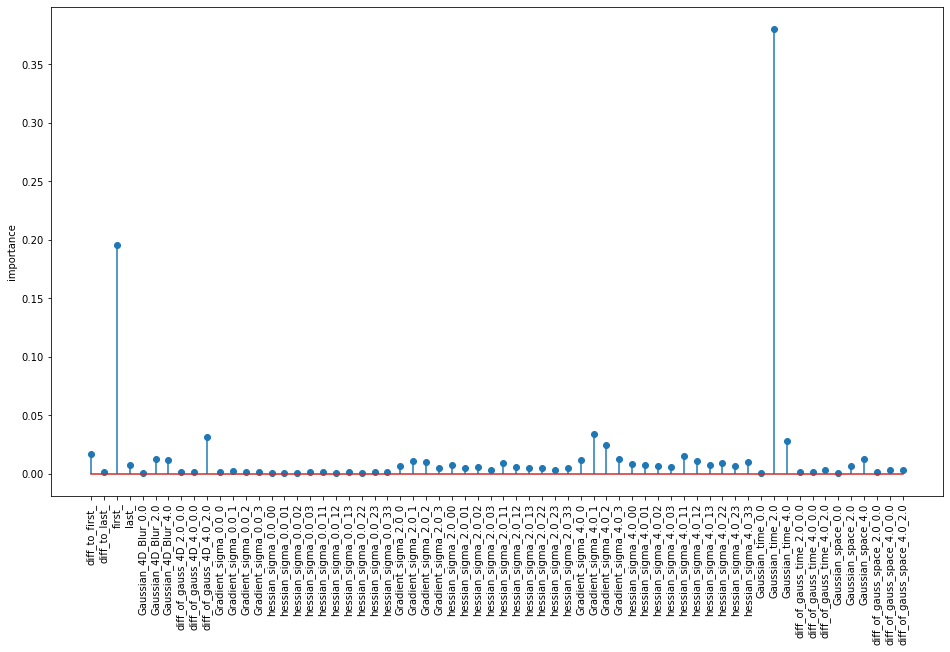

In [419]:
plt.figure(figsize=(16,9))
plt.stem(TS.feature_names, TS.clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance') 

KilledWorker: ("('rechunk-split-rechunk-merge-b612c0ed135b91be7786c033af4a7342', 0, 1, 3, 1)", <WorkerState 'tcp://127.0.0.1:46353', name: 6, status: closed, memory: 0, processing: 45>)

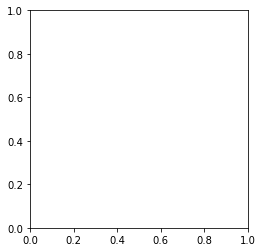

In [733]:
i = 1
plt.imshow(TS.current_feat_stack[:,:,i], vmin=6e4)
plt.title(TS.feature_names[i])


In [251]:
# TS.current_im8 = tfs.adjust_image_contrast(TS.current_im8, 50,200)

### when done, maybe save the classifier

In [420]:
TS.pickle_classifier()

### use an existing trainingset to train classifier (adhere to label image naming convention)

In [ ]:
# TS.train()

In [421]:
pickle.dump(TS.training_dict, open(os.path.join(TS.training_path, 'training_dict.p'),'wb'))

In [26]:
# TS.pickle_classifier()

In [422]:
from segmentation import segmentation
import pickle

In [423]:
SM = segmentation(training_path = training_path, classifier_path=os.path.join(training_path, 'classifier.p'))

In [425]:
SM.import_classifier(TS.clf)
# SM.clf = pickle.load(open(os.path.join(training_path, 'classifier.p'), 'rb'))

In [430]:
SM.import_feature_data(IF.result)

In [32]:
training_path

'/mpc/homes/fische_r/NAS/testing/TIM_tomo/cropped'

In [33]:
# SM.lazy = False
# part_ds = SM.feat_data.feature_stack[:,:,:,:10,:]

In [34]:
# part_ds

In [35]:
# part1 = part_ds.data

In [36]:
# type(part1)

In [37]:
# part1a = part1.compute()

In [38]:
# type(part1a)

In [39]:
# pickle.dump(part1a, open(os.path.join(training_path, 'part1a.p'), 'wb'))

In [40]:
# part1a = pickle.load(open(os.path.join(training_path, 'part1a.p'), 'rb'))

In [41]:
# shp = part1a.shape
# num_feat = shp[-1]

In [42]:
# clf = SM.clf

In [43]:
# clf.n_jobs = 32

In [44]:
# part1a = part1a.reshape(-1,num_feat)

In [45]:
# seg1 = clf.predict(part1a)

In [46]:
# seg1 = seg1.reshape(shp[:4]).astype(np.uint8)

In [47]:
# SM.classify_all()

In [426]:
clf = SM.clf
clf.n_jobs = 16

# part = SM.feat_data.feature_stack[:,:,:,:10,:]
# part1 = part.data
# part1 = part1.compute()

In [50]:
# shp = part1.shape
# num_feat = part1.shape[-1]
# part1 = part1.reshape(-1,num_feat)
# seg1 = clf.predict(part1)

In [52]:
# seg1 = seg1.reshape(shp[:4]).astype(np.uint8)

In [53]:
# segs = seg1
# pickle.dump(segs, open(os.path.join(training_path, 'seg1.p'), 'wb'))

In [427]:
parts = []
for i in range(10,150,10):
    parts.append((i-10,i))

In [428]:
parts 

[(0, 10),
 (10, 20),
 (20, 30),
 (30, 40),
 (40, 50),
 (50, 60),
 (60, 70),
 (70, 80),
 (80, 90),
 (90, 100),
 (100, 110),
 (110, 120),
 (120, 130),
 (130, 140)]

In [ ]:
# parts = [(20,40),(40,60),(60,80),(80,100),(100,120), (120,140)]
flag = True
for pa in parts:
    print(pa)
    part = SM.feat_data.feature_stack[:,:,:,pa[0]:pa[1],:]
    part = part.data
    part1 = part.compute()
    shp = part1.shape
    num_feat = part1.shape[-1]
    part1 = part1.reshape(-1,num_feat)
    seg = clf.predict(part1)
    seg = seg.reshape(shp[:4]).astype(np.uint8)
    if flag:
        segs = seg
        flag = False
    else:
        segs = np.concatenate([segs,seg], axis=-1)
    
pickle.dump(segs, open(os.path.join(training_path, 'segs.p'), 'wb'))

(0, 10)


In [67]:
# nsegs = [segs[i*500:(i+1)*500,...] for i in range(14)]

In [434]:
segs.shape

(500, 169, 500, 120)

In [436]:
seg_data = segs

In [34]:
import os
import xarray as xr
import matplotlib.pyplot as plt

In [437]:
path = os.path.join(training_path, 'segmented.nc')

In [438]:
# # TODO: propagate labels from raw data
# #TODO: if self.segmented_data is a dask array, rechunk for saving
shp = seg_data.shape
segdata = xr.Dataset({'segmented': (['x','y','z','time'], seg_data)},
                               coords = {'x': np.arange(shp[0]),
                               'y': np.arange(shp[1]),
                               'z': np.arange(shp[2]),
                               'time': np.arange(shp[3]),
                               'feature': SM.feature_names}
                     )
# # data.to

In [440]:
segdata.to_netcdf(path)

In [441]:
segdata = xr.open_dataset(path)

In [449]:
segdata.close()

2022-10-03 09:02:18,398 - distributed.nanny - WARNING - Restarting worker
2022-10-03 09:02:18,634 - distributed.nanny - WARNING - Restarting worker
2022-10-03 09:02:18,637 - distributed.nanny - WARNING - Restarting worker
2022-10-03 09:02:18,639 - distributed.nanny - WARNING - Restarting worker
2022-10-03 09:02:18,846 - distributed.nanny - WARNING - Restarting worker
2022-10-03 09:02:19,063 - distributed.nanny - WARNING - Restarting worker
2022-10-03 09:02:19,764 - distributed.nanny - WARNING - Restarting worker
2022-10-03 09:02:19,767 - distributed.nanny - WARNING - Restarting worker
2022-10-03 09:02:19,963 - distributed.nanny - WARNING - Restarting worker
2022-10-03 09:02:20,188 - distributed.nanny - WARNING - Restarting worker
2022-10-03 09:02:20,402 - distributed.nanny - WARNING - Restarting worker


In [42]:
# TS.plot_importance()

In [43]:
plt.imshow(seg_data[:,168,:,-1])

NameError: name 'seg_data' is not defined

In [36]:
import skimage
from scipy import ndimage

In [442]:
test = segdata['segmented'].sel(time=0)

In [443]:
test = test.data
water = (test==1).astype(int)
fiber = (test==2).astype(int)

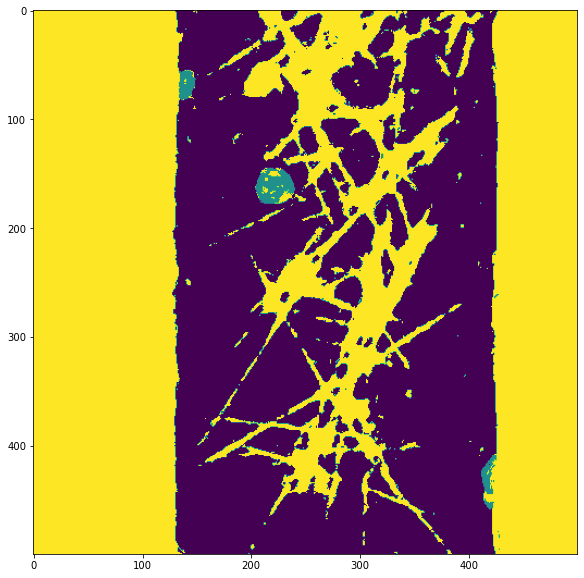

In [447]:
plt.figure(figsize=(10,10))
plt.imshow(segs[:,100,:,60])

In [56]:
filt = ndimage.binary_opening(fiber)

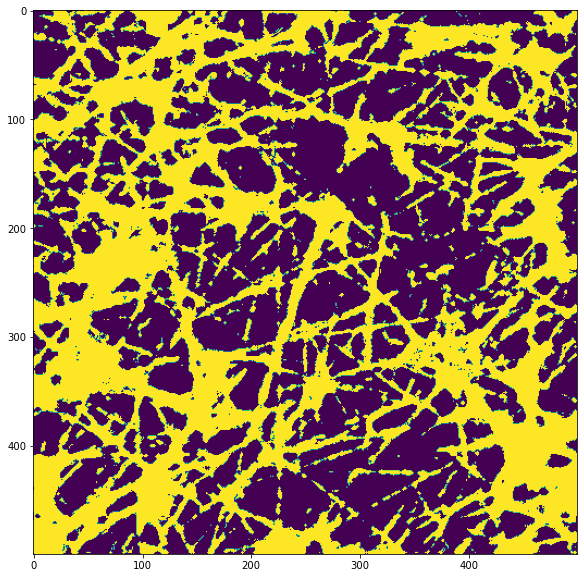

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(filt[:,120,:])

In [58]:
data.close()